In [1]:
import pyspark
from pyspark.sql import SparkSession,SQLContext
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, auc
import time

In [2]:
spark=SparkSession.builder.appName('Australian_rain_prediction').getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

**Read dataset**

In [3]:
df=spark.read.csv("gs://bucketbigdataman/dataset/Australia1.csv",inferSchema=True,header=True)

In [4]:
print(df.head())

22/12/09 12:06:53 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, Evaporation=5.472515506887167, Sunshine=8.5, WindGustSpeed=44.0, WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Cloud9am=8.0, Cloud3pm=5.0, RainToday=0.0, RainTomorrow=0.0, Month=12, Location_Albany=0, Location_Albury=1, Location_AliceSprings=0, Location_BadgerysCreek=0, Location_Ballarat=0, Location_Bendigo=0, Location_Brisbane=0, Location_Cairns=0, Location_Canberra=0, Location_Cobar=0, Location_CoffsHarbour=0, Location_Dartmoor=0, Location_Darwin=0, Location_GoldCoast=0, Location_Hobart=0, Location_Katherine=0, Location_Launceston=0, Location_Melbourne=0, Location_MelbourneAirport=0, Location_Mildura=0, Location_Moree=0, Location_MountGambier=0, Location_MountGinini=0, Location_Newcastle=0, Location_Nhil=0, Location_NorahHead=0, Location_NorfolkIsland=0, Location_Nuriootpa=0, Location_PearceRAAF=0, Location_Penrith=0, Location_Perth=0, Location_PerthAirport=0, Location_Portland=0, Location_R

In [5]:
print(df.columns)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow', 'Month', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Locati

In [6]:
start_time=time.time()

**Pipeline**

In [7]:
df_1 = df.drop('RainTomorrow')

In [8]:
assembler = VectorAssembler(inputCols=df_1.columns, outputCol="features_to_scale")

In [9]:
scaler = MinMaxScaler(inputCol="features_to_scale", outputCol="features_scaled")

In [10]:
model = GBTClassifier(labelCol="RainTomorrow", featuresCol="features_scaled", maxIter=10, stepSize=0.005, maxDepth=8)

In [11]:
pipeline = Pipeline(stages=[assembler, scaler, model])

**Split the dataset**

In [12]:
training_data, test_data = df.randomSplit([0.75, 0.25])

**Training**

In [13]:
pipeline_model = pipeline.fit(training_data)

**Test**

In [14]:
predictions = pipeline_model.transform(test_data)

In [15]:
predictions.select("prediction", "RainTomorrow").show(100)

+----------+------------+
|prediction|RainTomorrow|
+----------+------------+
|       0.0|         1.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         1.0|
|       0.0|         1.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|

**Model evaluation**

In [16]:
t_test=predictions.select('RainTomorrow').toPandas()
t_hat=predictions.select('prediction').toPandas()

In [17]:
print("\nAccuracy score on the test set: ", accuracy_score(t_test, t_hat))
print("\nF1-score score on the test set: ", f1_score(t_test, t_hat))


Accuracy score on the test set:  0.8405788761976005

F1-score score on the test set:  0.5728162824762932


In [18]:
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(t_test, t_hat)))
print(classification_report(t_test,t_hat))

Test-set accuracy score: 0.8406
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     27048
         1.0       0.71      0.48      0.57      7709

    accuracy                           0.84     34757
   macro avg       0.79      0.71      0.74     34757
weighted avg       0.83      0.84      0.83     34757



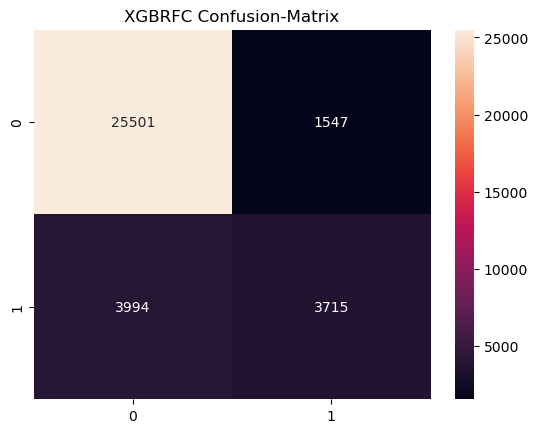

In [19]:
ax = plt.axes()
cm = confusion_matrix(t_test, t_hat)
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('XGBRFC Confusion-Matrix')
plt.show()

In [20]:
print(time.time()-start_time)

35.53734588623047
